In [51]:
import os
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plot
from IPython.display import display
import time
import numpy as np
import math


In [52]:
def show_images(images, title):
    classs = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    num_showed_imgs_x = 7
    num_showed_imgs_y = 7

    figsize = (15, 15)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    dataiter = iter(images)
    for i, ax in enumerate(axes.flat):
        image = images[i][0] / 2 + 0.5
        nimg = image.numpy().transpose(1, 2, 0)
        ax.imshow(nimg)
        ax.text(1, 1, classs[images[i][1]], bbox=dict(fill=False, edgecolor='blue', linewidth=3))
     


Files already downloaded and verified
Files already downloaded and verified
Number of train samples: 50000
Number of test samples: 10000


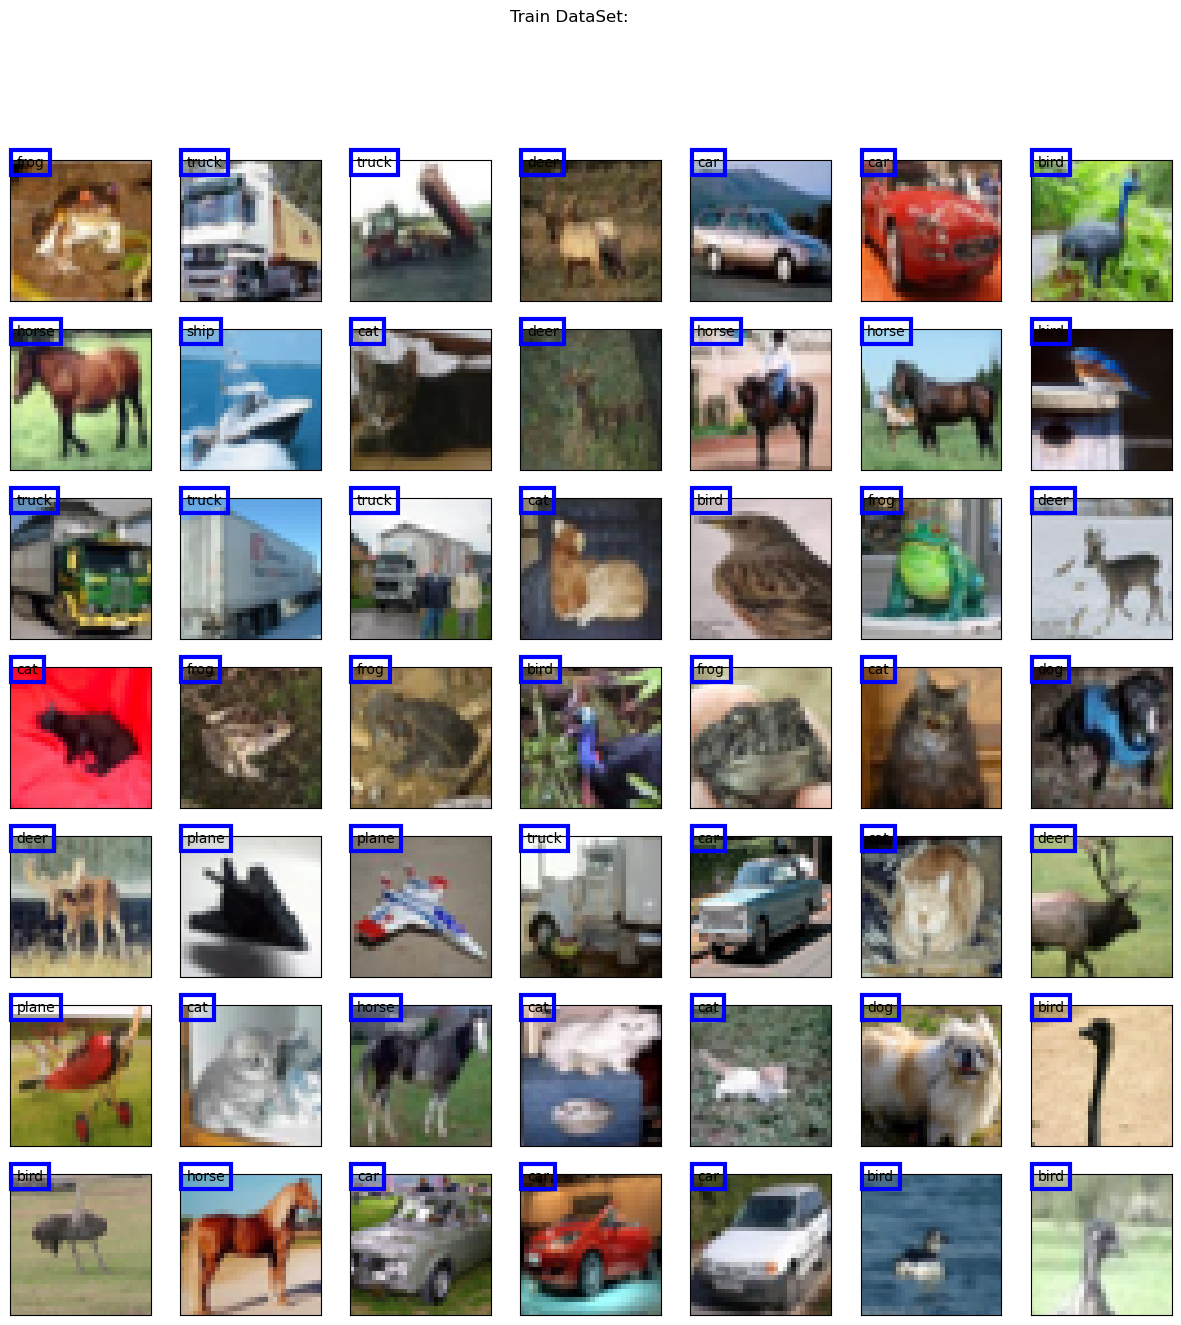

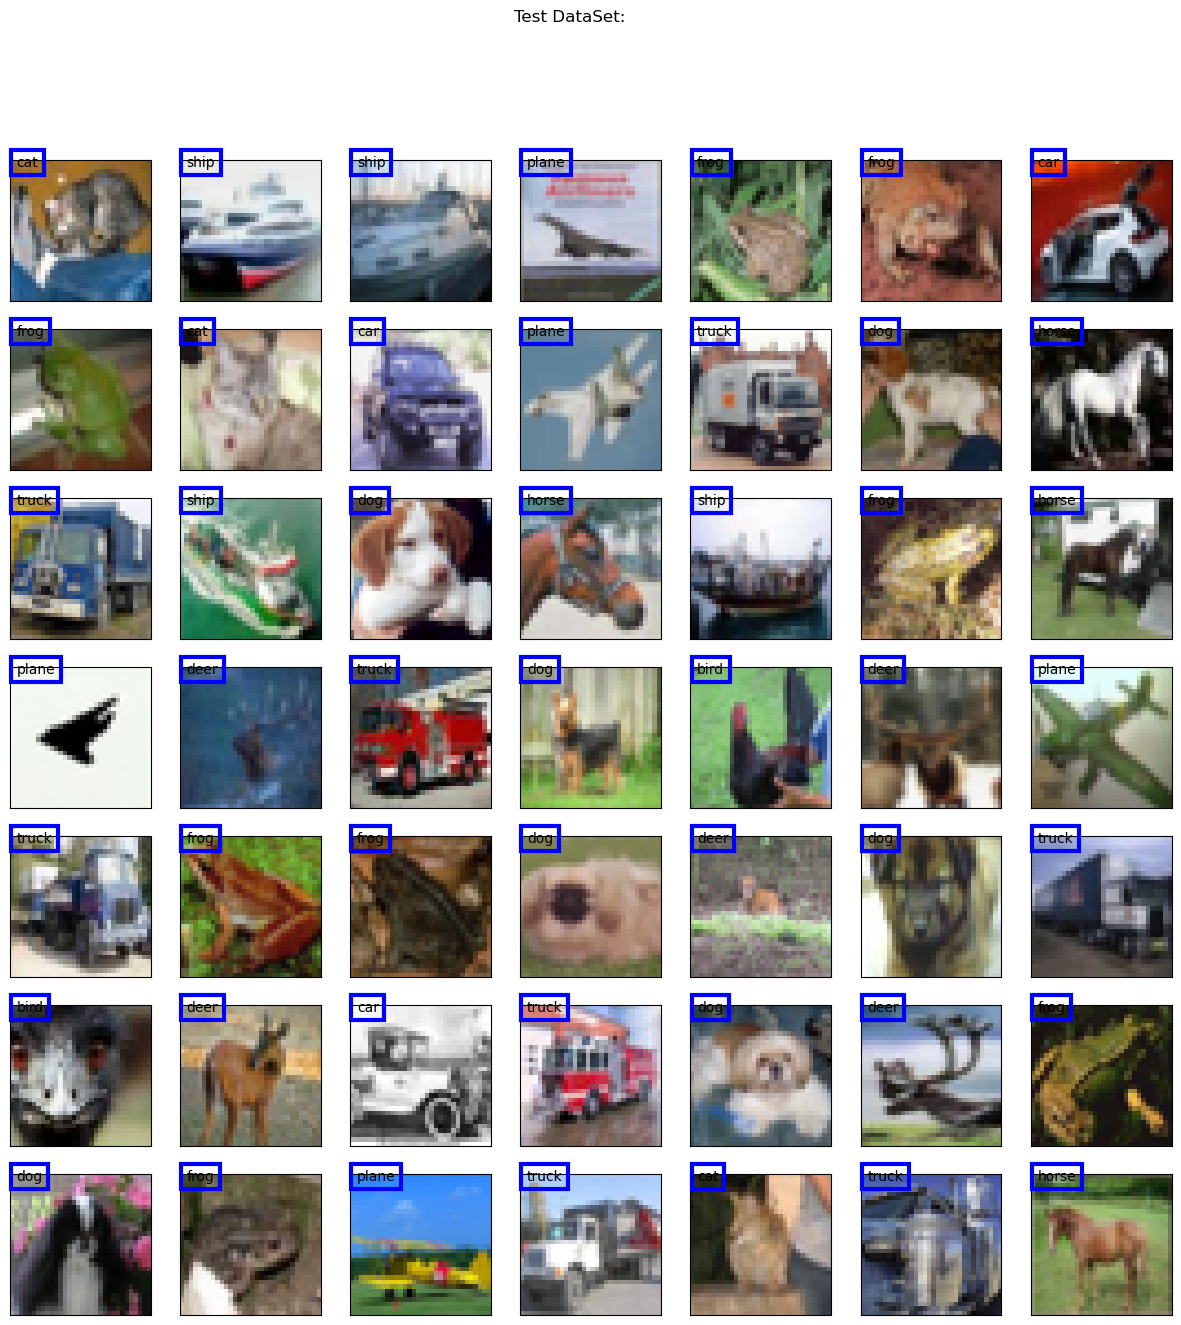

In [53]:
dir_name = os.getcwd()
batch_size = 64

transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = True, download = True,
    transform = transformations
)
test_dataset = torchvision.datasets.CIFAR10(
    root = dir_name, train = False, download = True,
    transform = transformations
)
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

print('Number of train samples: {}'.format(len(train_dataset)))
show_images(train_dataset, "Train DataSet: ")

print('Number of test samples: {}'.format(len(test_dataset)))
show_images(test_dataset, "Test DataSet: ")


In [54]:
import torch.nn.functional as func
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*10*10, 10)

    def forward(self, inp):
        c_1 = self.conv1(inp)
        b_1 = self.bn1(c_1)
        output = func.relu(b_1)
        c_2 = self.conv2(output)
        b_2 = self.bn2(c_2)
        output = func.relu(b_2)     
        output = self.pool(output) 
        c_4 = self.conv4(output)
        b_4 = self.bn4(c_4)
        output = func.relu(b_4)
        c_5 = self.conv5(output)
        b_5 = self.bn5(c_5)
        output = func.relu(b_5)     
        output = output.view(-1, 24*10*10)
        output = self.fc1(output)

        return output
    
# инит модели 
model = CNNNet()
print(model)

CNNNet(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2400, out_features=10, bias=True)
)



(process:8848): Pango-WARNING **: 22:57:09.724: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


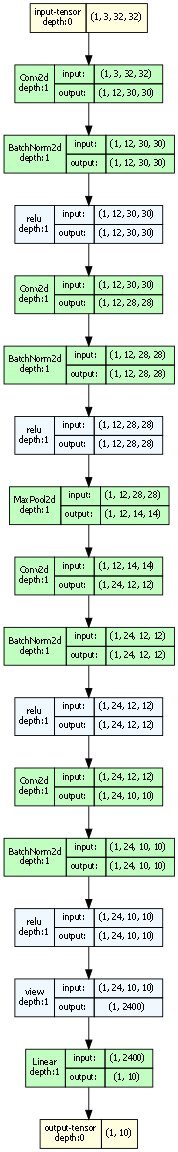

In [55]:
import graphviz
from torchview import draw_graph
graphviz.set_jupyter_format("png")
model_graph = draw_graph(model, input_size=(1,3,32,32), expand_nested=True)
model_graph.visual_graph

In [56]:
from torch.optim import Adam
learning_rate = 0.001 
num_epochs = 30
w_dec = 0.0001

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=w_dec)


# Выбор устройства для вычислений
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)
print(f'Dev: {torch.cuda.get_device_name(device)}')

cuda:0
Dev: NVIDIA GeForce GTX 1650


In [57]:
# Accuracy
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader: # по всему
            # выход сети 
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0) # кол-во изображений ( batch_size )
            tp += (predicted == labels).sum() # то что совпало!
    return tp / n

In [58]:
for epoch in range(num_epochs):
    start_time = time.time()
    for i, (images, labels) in enumerate(train_data_loader): # получаем тренировочные данные
        # добавим данные на устройство
        images = images.to(device)
        labels = labels.to(device)
        # Прямой проход
        outputs = model(images) # выход сети
        loss = loss_fn(outputs, labels) # получаем ошибку
        # Обратный проход
        optimizer.zero_grad() # обнуляем градиенты
        loss.backward() # вычисление градиента функции ошибки (back propagation)
        optimizer.step() # обновим параметры модели
    
    end_time = time.time()
    res = end_time - start_time
    print('Epoch[{}]: accuracy = {}, time = {}'.
          format(epoch, get_accuracy(train_data_loader, model),res))
  

Epoch[0]: accuracy = 0.6482599973678589, time = 21.946895599365234
Epoch[1]: accuracy = 0.6978399753570557, time = 21.309784412384033
Epoch[2]: accuracy = 0.7450599670410156, time = 20.992836952209473
Epoch[3]: accuracy = 0.7675999999046326, time = 21.538602828979492
Epoch[4]: accuracy = 0.770579993724823, time = 21.626108407974243
Epoch[5]: accuracy = 0.7933599948883057, time = 21.01406502723694
Epoch[6]: accuracy = 0.8083599805831909, time = 20.97320318222046
Epoch[7]: accuracy = 0.8025199770927429, time = 20.962932586669922
Epoch[8]: accuracy = 0.8291999697685242, time = 21.748661518096924
Epoch[9]: accuracy = 0.8251000046730042, time = 21.901153326034546
Epoch[10]: accuracy = 0.8430799841880798, time = 25.13478398323059
Epoch[11]: accuracy = 0.855679988861084, time = 24.410029888153076
Epoch[12]: accuracy = 0.8590199947357178, time = 20.905770540237427
Epoch[13]: accuracy = 0.8776199817657471, time = 21.531355619430542
Epoch[14]: accuracy = 0.8800999522209167, time = 20.97268986701

In [59]:
start_time = time.time()
print('Test accuracy: {}'.format(get_accuracy(test_data_loader, model)))
end_time = time.time()

Test accuracy: 0.7050999999046326
